In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from market_profile import MarketProfile

# Load the CSV file
df = pd.read_csv('./BTCUSDT_DATA/BTCUSDT-15m-2019-10.csv')

# Convert Unix time to datetime
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')

# Set the date as the index
#df = df.set_index('open_time')

df.drop(['close_time',  'quote_volume', 'count', 'taker_buy_base_volume', 'taker_buy_quote_volume'], axis=1, inplace=True)
df

,open_time,open,high,low,close,volume
0,2019-10-01 00:00:00,8281.40,8281.40,8219.28,8237.03,0.995126
1,2019-10-01 00:15:00,8246.98,8246.98,8221.39,8223.74,0.254898
2,2019-10-01 00:30:00,8210.27,8217.55,8201.90,8217.55,0.276180
3,2019-10-01 00:45:00,8219.84,8219.84,8201.31,8201.83,0.207412
4,2019-10-01 01:00:00,8202.23,8214.86,8180.16,8212.14,0.641905
...,...,...,...,...,...,...
2971,2019-10-31 22:45:00,9120.70,9127.78,9090.41,9121.56,6.344303
2972,2019-10-31 23:00:00,9120.23,9148.65,9113.59,9140.07,2.067867
2973,2019-10-31 23:15:00,9141.55,9157.71,9121.74,9137.20,2.888953
2974,2019-10-31 23:30:00,9137.74,9144.05,9131.92,9140.20,1.850224


In [43]:
import time
def scenario_one(open_price, value_area_high, value_area_low, current_price, volume_1, volume_2):
    if open_price > value_area_high and current_price >= value_area_high:
        return "Scenario One: Long"
    elif current_price < value_area_high and current_price > value_area_low and volume_1 > volume_2:
        return "scenario One: Long "
    else:
        return "Scenario One: None "

def scenario_two(open_price, value_area_high, current_price, volume):
    if open_price > value_area_high and current_price <= value_area_high:
        return "Scenario Two: Short"
    else:
        return "Scenario Two: None"
def scenario_three(open_price, value_area_low, current_price, volume):
    if open_price < value_area_low and current_price >= value_area_low:
        return "Scenario Three: Long"
    else:
        return "Scenario Three: None"
def scenario_four(open_price, value_area_high, value_area_low, current_price, volume_1, volume_2):
    if open_price < value_area_low and current_price <= value_area_low:
        return "Scenario Four: Short"
    elif open_price < value_area_high and current_price > value_area_low and volume_1 > volume_2:
        return "Scenario Four: Short"
    else:
        return "Scenario Four: None"
def scenario_five(open_price, value_area_high, value_area_low, current_price):

    if open_price > value_area_low and open_price < value_area_high  and current_price > value_area_low and current_price < value_area_high:
        return "Scenario Five: Neutral"
    else:
        return "Scenario Five: None"
def simulate_short_leverage(initial_balance, leverage, buy_position, sell_price, short_long):
    """
    Simulates short selling with leverage.

    Args:
        initial_balance (float): Initial account balance.
        leverage (float): Leverage factor (e.g., 2 for 2x leverage).
        price_change_pct (float): Percentage change in asset price (negative for price decrease).

    Returns:
        float: Final account balance after shorting.
    """
    # Calculate the effective leverage
    leveraged = leverage * initial_balance

    # Calculate the new balance after price change
    if short_long == "Short":
        PnL_short = (buy_position - sell_price)*(leveraged/buy_position)
        print(PnL_short)
        new_balance = initial_balance + PnL_short
    elif short_long == "Long":
        PnL_long = (sell_price - buy_position)*(leveraged/buy_position)
        new_balance = initial_balance + PnL_long
    return new_balance
#extract time and volume columns
data = df[['open_time', 'volume']]
initial_balance = 100  # Initial account balance in USD
leverage = 5         # Leverage ratio (10x)
for i in range(1, 28):
    #extract time and volume columns
    data = df[['open_time', 'volume']]
    #get rows from 2019-10-01 time 07:00:00 to 2019-10-02 time 09:00:00'
    if i < 8:
        data = data[(data['open_time'] >= f'2019-10-0{i} 07:00:00') & (data['open_time'] <= f'2019-10-0{i+1} 09:00:00')]
    elif i == 9:
        data = data[(data['open_time'] >= f'2019-10-0{i} 07:00:00') & (data['open_time'] <= f'2019-10-{i+1} 09:00:00')]
    else:
        data = data[(data['open_time'] >= f'2019-10-{i} 07:00:00') & (data['open_time'] <= f'2019-10-{i+1} 09:00:00')]
    # Sort DataFrame by volume in descending order
    data.sort_values(by="volume", ascending=False, inplace=True)
    # Calculate total traded volume
    total_volume = data["volume"].sum()

    # Determine 70% of total volume
    value_area_target = total_volume * 0.7

    # Initialize Value Area with POC
    poc = data.iloc[0]
    value_area = [poc]
    current_volume = poc["volume"]

    # Iterate above and below POC
    poc_index = data.index.get_loc(poc.name)
    above_index, below_index = poc_index + 1, poc_index - 1

    while current_volume < value_area_target:
        if above_index < len(data):
            above_row = data.iloc[above_index]
        else:
            above_row = None
        
        if below_index >= 0:
            below_row = data.iloc[below_index]
        else:
            below_row = None
        
        if above_row is None and below_row is None:
            break
        
        if not below_row or (above_row and above_row["volume"] > below_row["volume"]):
            value_area.append(above_row)
            current_volume += above_row["volume"]
            above_index += 1
        else:
            value_area.append(below_row)
            current_volume += below_row["volume"]
            below_index -= 1

    # Determine VAH and VAL
    vah = max(value_area, key=lambda x: x["open_time"])
    val = min(value_area, key=lambda x: x["open_time"])

    #print(f"Value Area High (VAH): {vah['open_time']} with volume {vah['volume']}")
    #print(f"Value Area Low (VAL): {val['open_time']} with volume {val['volume']}")
    #print(f"Total Value Area Volume: {current_volume}")
    #print(f"Value Area Target (70% of Total Volume): {value_area_target}")
    #print(f"POC (Point of Control): {poc['open_time']} with volume {poc['volume']}")
    #get closing price for VAH and VAL from the original dataframe
    vah_close = df[df['open_time'] == vah['open_time']]['close'].values[0]
    val_close = df[df['open_time'] == val['open_time']]['close'].values[0]
    #print(f"Value Area High (VAH) close price: {vah_close}")
    #print(f"Value Area Low (VAL) close price: {val_close}")
    #get point of control price from the original dataframe
    poc_close = df[df['open_time'] == poc['open_time']]['close'].values[0]
    #print(f"Point of Control (POC) close price: {poc_close}")
    #get specific open price, volume and current price from specific time
    if i<8:
        open_price = df[df['open_time'] == f'2019-10-0{i+1} 09:00:00']['open'].values[0]
        volume_1 = df[df['open_time'] == f'2019-10-0{i+1} 09:00:00']['volume'].values[0]
        volume_2 = df[df['open_time'] == f'2019-10-0{i+1} 09:30:00']['volume'].values[0]
        current_price = df[df['open_time'] == f'2019-10-0{i+1} 09:30:00']['open'].values[0]
    else:
        open_price = df[df['open_time'] == f'2019-10-{i+1} 09:00:00']['open'].values[0]
        volume_1 = df[df['open_time'] == f'2019-10-{i+1} 09:00:00']['volume'].values[0]
        volume_2 = df[df['open_time'] == f'2019-10-{i+1} 09:30:00']['volume'].values[0]
        current_price = df[df['open_time'] == f'2019-10-{i+1} 09:30:00']['open'].values[0]
    recommendation_1 = scenario_one(open_price , vah_close, val_close, current_price, volume_1,volume_2 )
    recommendation_2 = scenario_two(open_price, vah_close, current_price, volume_1)
    recommendation_3 = scenario_three(open_price, val_close, current_price, volume_1)
    recommendation_4 = scenario_four(open_price, vah_close, val_close, current_price, volume_1, volume_2)
    recommendation_5 = scenario_five(open_price, vah_close, val_close, current_price)
    #get final recommendation based on the 5 scenarios above which is not the string "None"
    final_recommendation = [recommendation_1, recommendation_2, recommendation_3, recommendation_4, recommendation_5]
    #check for each recommendation and get the first one that does not contain the string "None"
    decision = ""
    for recommendation in final_recommendation:
        if "None" not in recommendation:
            print("\n"+recommendation)
            decision = recommendation
            break
    #get the row  index of df[df['open_time'] == f'2019-10-0{i+1} 09:30:00']
    if i<8:
        index = df[df['open_time'] == f'2019-10-0{i+1} 09:30:00'].index[0]
    else:
        index = df[df['open_time'] == f'2019-10-{i+1} 09:30:00'].index[0]
    #do a for loop  getting the open and close prices for the next 20 rows after the index
    btc_price = current_price      # Current BTC price in USD
    for i in range(20):
        temp_open = df.iloc[index + i]['open']
        temp_close = df.iloc[index + i]['close']
        
        if "Short" in decision:
            target_price = current_price*0.998   # Target price to close the position in USD
            if current_price> temp_close or current_price > temp_open:
                print(f"Shorted: WIN, IN:{current_price}, OUT:  open - {temp_open} close-{temp_close}")
                #btc_price is based on either open or close price if either is greater than the target price
                btc_price = temp_open if current_price > temp_open else temp_close
                initial_balance = simulate_short_leverage(initial_balance, leverage, current_price, btc_price, "Short")
                print(f"Ending Balance: {initial_balance}")
                break
            else:
                print(f"Longed: LOSE, IN:{current_price},  OUT:  open - {temp_open} close-{temp_close}")
                stop_loss = current_price*1.05
                btc_price = temp_open if current_price < temp_open else temp_close
                if btc_price >= stop_loss:
                    initial_balance = simulate_short_leverage(initial_balance, leverage, current_price, btc_price, "Short")
                    print(f"Ending Balance: {initial_balance}")
                    break
        elif "Long" in decision:
            if current_price < temp_open or current_price< temp_close:
                print(f"Longed: WIN, IN:{current_price}, OUT:  open - {temp_open} close-{temp_close}")
                btc_price = temp_open if current_price< temp_open else temp_close
                percentage_change = (btc_price - current_price) / current_price
                initial_balance = simulate_short_leverage(initial_balance, leverage, current_price, btc_price, "Long")
                print(f"Ending Balance: {initial_balance}")
                break
            else:
                print(f"Shorted: LOSE, IN:{current_price},  OUT:  open - {temp_open} close-{temp_close}")
                stop_loss = current_price*0.95
                btc_price = temp_open if current_price > temp_open else temp_close
                if btc_price >= stop_loss:
                    percentage_change = (btc_price - current_price) / current_price
                    initial_balance = simulate_short_leverage(initial_balance, leverage, current_price, btc_price, "Long")
                    print(f"Ending Balance: {initial_balance}")
                    break
        if i == 19:
            print(f"Ending Balance: {initial_balance}")




Scenario Four: Short
Shorted: WIN, IN:8238.69, OUT:  open - 8238.69 close-8228.54
0.6159959896536727
Ending Balance: 100.61599598965367

Scenario Two: Short
Longed: LOSE, IN:8261.56,  OUT:  open - 8261.56 close-8269.84
Longed: LOSE, IN:8261.56,  OUT:  open - 8267.29 close-8268.18
Longed: LOSE, IN:8261.56,  OUT:  open - 8270.68 close-8269.95
Shorted: WIN, IN:8261.56, OUT:  open - 8262.32 close-8236.97
1.4973850830748663
Ending Balance: 102.11338107272853

Scenario Four: Short
Longed: LOSE, IN:8117.32,  OUT:  open - 8117.32 close-8117.32
Shorted: WIN, IN:8117.32, OUT:  open - 8114.4 close-8121.4
0.18366349529917186
Ending Balance: 102.2970445680277

Scenario Four: Short
Longed: LOSE, IN:8086.23,  OUT:  open - 8086.23 close-8089.52
Shorted: WIN, IN:8086.23, OUT:  open - 8094.61 close-8082.86
0.21316549256837997
Ending Balance: 102.51021006059608

Scenario Four: Short
Shorted: WIN, IN:7920.88, OUT:  open - 7920.88 close-7916.47
0.2853660365812977
Ending Balance: 102.79557609717737

Scenar

In [26]:
if 8238.69 < 8228.54:
    print("yes")

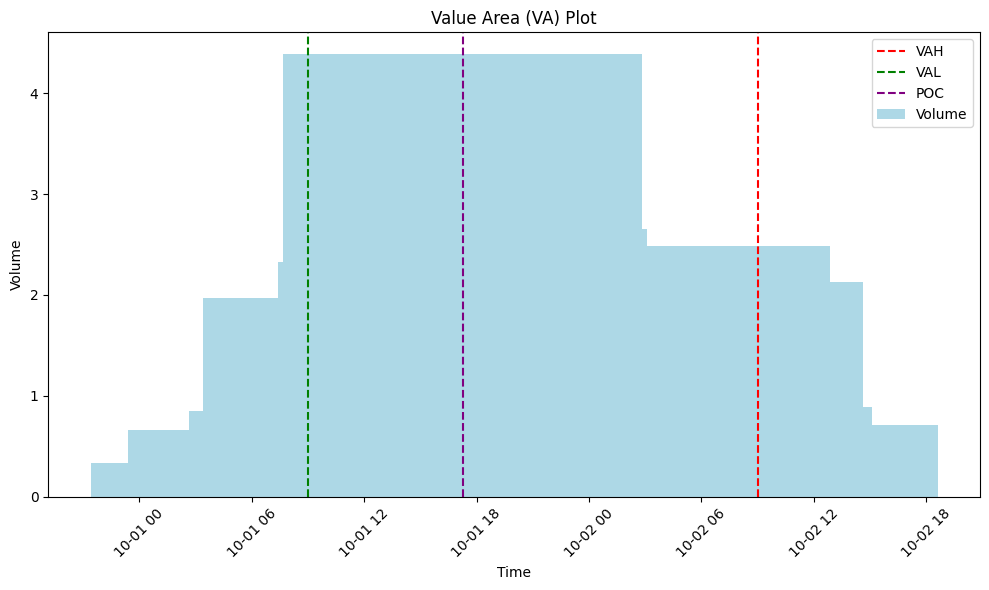

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
# Calculate VAH and VAL (replace with your actual values)
vah_time = vah['open_time']
val_time = val['open_time']
poc_time = poc['open_time']
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(data["open_time"], data["volume"], color="lightblue", label="Volume")
plt.axvline(x=vah_time, color="red", linestyle="--", label="VAH")
plt.axvline(x=val_time, color="green", linestyle="--", label="VAL")
plt.axvline(x=poc_time, color="purple", linestyle="--", label="POC")  # Add POC line

plt.xlabel("Time")
plt.ylabel("Volume")
plt.title("Value Area (VA) Plot")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show or save the plot
plt.show()